# BBH Postmerger GW Representations

This notebook explores the time-, frequency- and time-frequency representations of BBH merger/post-merger signals


In [6]:
%matplotlib inline
import matplotlib
import sys, os, h5py
import copy
import numpy as np
from matplotlib import pyplot as plt
import cwt
from scipy.interpolate import interp1d

import pycbc.waveform as wfutils
from pycbc.waveform import get_td_waveform,taper_timeseries
from pycbc.types import FrequencySeries
from pycbc.filter import sigma as optimal_snr

fig_width_pt = 510.
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

fontsize = 16
legendfontsize = 14

params={'text.usetex': True,
        'axes.labelsize': fontsize,
        'font.size': fontsize,
        'legend.fontsize': legendfontsize,
        'xtick.labelsize': fontsize,
        'ytick.labelsize': fontsize,
        'figure.figsize': fig_size,
        'font.weight': 'normal'
       }


import pylab
pylab.rcParams.update(params)
pylab.rcParams['axes.linewidth'] = 1
pylab.rc('axes', linewidth=1)

def touchbox(ax):
    ax.tick_params('both', length=5, width=1, which='major')
    ax.tick_params('both', length=3.5, width=1, which='minor')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    return


## Data aquisition

### Notebook configuration
working & save directories, filenames etc

In [7]:
waveform_dir="/waves"
waveform_file=os.path.join(waveform_dir,"GTwaves.txt")
savepath = "/bbh-tfmaps"
total_mass=100
sample_frequency = 4096

### Waveform configuration
Choice of waveform (filename), masses, ...

In [8]:
waves = np.genfromtxt(waveform_file, dtype=str)


numrel_files = [os.path.join(waveform_dir, waveform)
                for waveform in np.genfromtxt(waveform_file, dtype=str)]

masses = total_mass*np.ones(len(numrel_files))
print masses
print numrel_files

[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
['/waves/GT0370.h5', '/waves/GT0448.h5', '/waves/GT0476.h5', '/waves/GT0477.h5', '/waves/GT0564.h5', '/waves/GT0577.h5', '/waves/GT0621.h5', '/waves/GT0622.h5', '/waves/GT0650.h5', '/waves/GT0651.h5', '/waves/GT0818.h5', '/waves/GT0900.h5']


## Generate Waveforms And Time-Frequency Analysis
### Time-Frequency Decomposition
Here, we decompose the time series data into a time frequency representation (i.e., image) for image classification.  In this example, we use a [continuous wavelet transform](https://www.mathworks.com/help/wavelet/continuous-wavelet-analysis.html?requestedDomain=true) ("CWT").

/bbh-tfmaps/GT0370 [1/12]


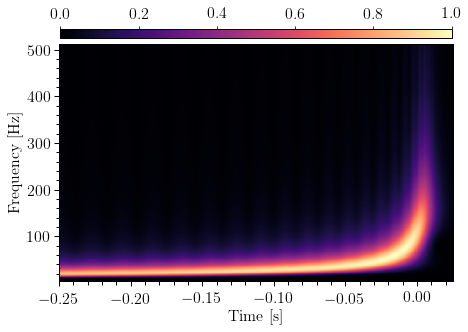

SystemExit: 

In [27]:
for n,(numrel_data, mass) in enumerate(zip(numrel_files, masses)):
    
    wavelabel=os.path.join(savepath, numrel_data.split('/')[-1].replace(".h5",""))

    print "%s [%d/%d]"%(wavelabel, n+1, len(numrel_files))
        
    f = h5py.File(numrel_data, 'r')

    hp, hc = get_td_waveform(approximant='NR_hdf5',
                                 numrel_data=numrel_data,
                                 mass1=f.attrs['mass1']*mass,
                                 mass2=f.attrs['mass2']*mass,
                                 spin1z=f.attrs['spin1z'],
                                 spin2z=f.attrs['spin2z'],
                                 delta_t=1.0/sample_frequency,
                                 f_lower=30.,
                                 inclination=0.0,
                                 coa_phase=0.0,
                                 distance=1000)

    f.close()

    # Resize / zero-pad to 10 seconds
    hp.resize(10*sample_frequency)
    hc.resize(10*sample_frequency)

    # Truncate and taper from maximum
    delay=0#int(1e-3 / delta_t)
    truncidx = np.argmax(abs(hp)) - delay
    hp_post = copy.deepcopy(hp)
    hp_post.data[:truncidx] = 0.0 
    hc_post = copy.deepcopy(hc)
    hc_post.data[:truncidx] = 0.0 

    # Taper waveform
    hp = taper_timeseries(hp, tapermethod="TAPER_START")
    hc = taper_timeseries(hc, tapermethod="TAPER_START")

    hp_post = taper_timeseries(hp_post, tapermethod="TAPER_START")
    hc_post = taper_timeseries(hc_post, tapermethod="TAPER_START")

    # Trim the timeseries before the CWT
    hp_red = hp[:int(sample_frequency)]

    
    #
    # Compute Continuous Wavelet Transform
    #
    
    # User input
    mother_freq=0.4
    max_scale=512

    fmin=sample_frequency*mother_freq/max_scale
    fmax=sample_frequency*mother_freq

    red_time = hp_red.sample_times - hp.sample_times[np.argmax(abs(hp_red))]

    cwt_result = cwt.build_cwt(hp_red.data, hp_red.sample_times, 
                               mother_freq=mother_freq, max_scale=max_scale)
    wtimes = np.copy(red_time)
    wfreqs = cwt_result['frequencies']
    wplane = cwt_result['map']

    # Eliminate freqs > Nyquist
    interpolant = interp1d(wfreqs, wplane, axis=0)
    wfreqs = np.arange(wfreqs.min(), 512)
    wplane = interpolant(wfreqs)


    #
    # Plot result
    #
    fig, ax = plt.subplots(figsize=fig_size)

    p_qstrain = ax.pcolormesh(wtimes, wfreqs, (abs(wplane)),
                              cmap='magma', rasterized=False,
                             vmin=0,vmax=1)

#     c_qstrain = ax.contour(wtimes, wfreqs, (abs(wplane)), 
#                 colors='lightgray', levels=np.logspace(-1,0,5))

    cbaxes = fig.add_axes([0.1275, 0.9, 0.77, 0.03]) 
    cbar=fig.colorbar(p_qstrain, orientation='horizontal', cax=cbaxes)

    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')

    ax.set_xlim(-0.25,0.025)

    ax.set_xlabel(r'$\textrm{Time [s]}$')
    ax.set_ylabel(r'$\textrm{Frequency [Hz]}$')
    ax.clabel(c_qstrain, inline=1, fmt="%.1f", fontsize=14)
    ax.minorticks_on()

    touchbox(ax)

    plt.show()
    

    sys.exit()